# 04. Generating Sets of Chemicals with the ChemicalMixtureCreator class

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from pathlib import Path
import numpy as np

In [9]:
import os
import sys
sys.path.append('../..')

In [19]:
import pylab as plt
%matplotlib inline

In [4]:
from vimms.Chemicals import ChemicalMixtureCreator

## Introduction

The `ChemicalMixtureCreator` offers the most simple method for creating chemical datasets for simulation allowing the generation of a dataset of chemicals in just a few lines of python.

The class requires several other classes to run:

- A class that can generate _formulas_
- A class that can generate RT and intensity for formulas
- A class that can generate chromatograms for formulas
- A class that can generate MS2 spectra for formulas

### `FormulaSampler`

An instance of a class extending `FormulaSampler` must be provided. This samples the chemicals that will appear. Note that `Formula` is abused here: in some cases the result is a chemical formula, but in others, just an m/z. Which it does has implications for the data generated (see below).  Currently, the following options are available:

- `DatabaseFormulaSampler`: samples formulas from a database provided. Code is given to generate from HMDB
- `UniformMZFormulaSampler`: samples _formulas_ (just masses) uniformly in an m/z range
- `PickEverythingFormulaSampler`: samples all formulas from a database
- `EvenMZFormulaSampler`: creates evenly spaced m/z, starting at 100Da, with 100 Da spacing. Mainly used for test cases.
- `MZMLFormulaSampler`: samples m/z values from a histogram of m/z taken from a user supplied mzML file

Examples of creating some of these objects

#### `DatabaseFormulaSampler`

In [7]:
from vimms.ChemicalSamplers import DatabaseFormulaSampler
from vimms.Common import load_obj

In [11]:
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','..','tests','fixtures'))
HMDB = os.path.join(data_dir,'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [ ]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

(array([ 95.,  95.,  94.,  95., 108., 105.,  95., 103., 117.,  93.]),
 array([100.18070129, 140.13752696, 180.09435263, 220.0511783 ,
        260.00800397, 299.96482964, 339.92165531, 379.87848098,
        419.83530665, 459.79213232, 499.74895799]),
 <BarContainer object of 10 artists>)

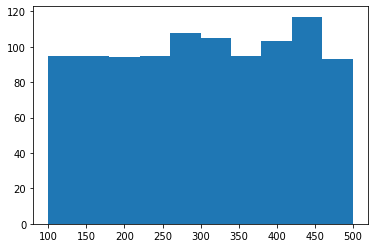

In [21]:
from vimms.ChemicalSamplers import UniformMZFormulaSampler
# create a formula sampler that samples masses uniformly between 100 and 500
df = UniformMZFormulaSampler(min_mz=100, max_mz=500)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

Loaded 364 scans


(array([161., 215., 451., 141.,  19.,   3.,   7.,   1.,   0.,   2.]),
 array([ 82.17358934, 147.7886142 , 213.40363906, 279.01866392,
        344.63368877, 410.24871363, 475.86373849, 541.47876335,
        607.0937882 , 672.70881306, 738.32383792]),
 <BarContainer object of 10 artists>)

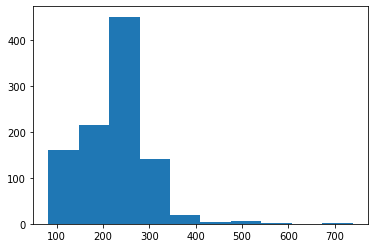

In [23]:
from vimms.ChemicalSamplers import MZMLFormulaSampler
MZML = os.path.join(data_dir, 'small_mzml.mzML')
df = MZMLFormulaSampler(MZML)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

### `RTAndIntensitySampler`

Passing an instance of this is optional. If nothing is passed, it defaults to `UniformRTAndIntensitySampler`

Available:

- `UniformRTAndIntensitySampler`: samples RT and intensity independently from uniform distributions (note that intensity is unifrom in log space)
- `MZMLRTandIntensitySampler`: samples RT and intensity independely from histograms produced from an mzML file

Examples:

#### `UniformRTAndIntensitySampler`

(array([665., 100.,  60.,  46.,  30.,  28.,  28.,  18.,  12.,  13.]),
 array([7.48074741e+00, 8.14084684e+02, 1.62068862e+03, 2.42729256e+03,
        3.23389649e+03, 4.04050043e+03, 4.84710437e+03, 5.65370831e+03,
        6.46031224e+03, 7.26691618e+03, 8.07352012e+03]),
 <BarContainer object of 10 artists>)

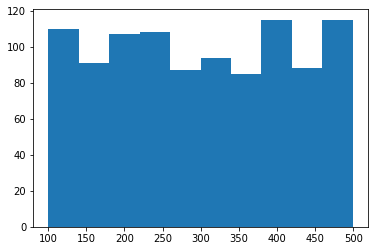

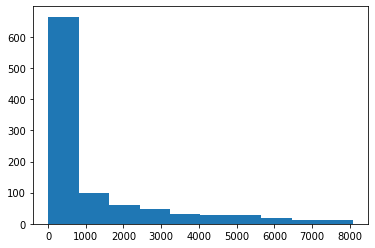

In [28]:
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler
ri = UniformRTAndIntensitySampler(min_rt=100, max_rt=500, min_log_intensity=2, max_log_intensity=9)
rt_list = []
intensity_list = []
for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)
plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### `MZMLRTandIntensitySampler`

Loaded 364 scans


(array([786., 109.,  44.,  23.,   8.,   6.,   7.,   7.,   6.,   4.]),
 array([ 123460.11217483, 1077296.26893841, 2031132.425702  ,
        2984968.58246559, 3938804.73922917, 4892640.89599276,
        5846477.05275635, 6800313.20951994, 7754149.36628352,
        8707985.52304711, 9661821.6798107 ]),
 <BarContainer object of 10 artists>)

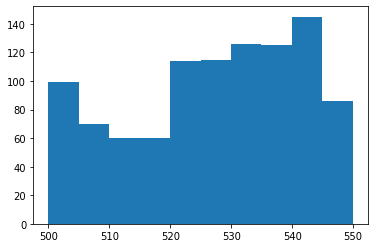

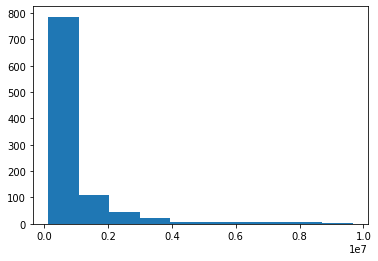

In [34]:
from vimms.ChemicalSamplers import MZMLRTandIntensitySampler
ri = MZMLRTandIntensitySampler(MZML)

rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

### `ChromatogramSampler`

This optional object defines where chromatograms should be sampled from for each formula. There are three options:

- `GaussianChromatogramSampler`: generates normal shape chromatographic peaks
- `ConstantChromoatogramSampler`: generates constant chromatographic (i.e. flat) peaks (mainly for testing)
- `MZMLChromatogramSampelr`: samples chromatograms from ROIs extracted from an mzML file

Note that in all cases, the `sample` method takes three arguments: a formula, an rt and an intensity. These are so that, in future we could condition the chromatogram finding on particular values of RT and intensity (e.g. high intensity = better peaks).

Examples:

#### `GaussianChomatogramSampler`

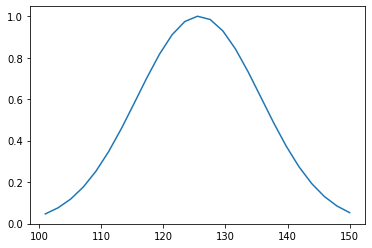

In [53]:
# grab a formula to use for example sampling
f_list = df.sample(1)
formula, name = f_list[0]
from vimms.ChemicalSamplers import GaussianChromatogramSampler
cs = GaussianChromatogramSampler(sigma=10)
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `ConstantChromatogramSampler`

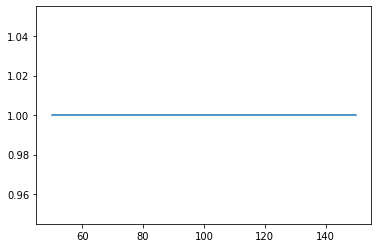

In [55]:
from vimms.ChemicalSamplers import ConstantChromatogramSampler
cs = ConstantChromatogramSampler()
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `MZMLChromatogramSampler`

2020-09-11 08:02:56.002 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:325 - Extracted 719 good ROIs from /Users/simon/git/vimms/tests/fixtures/small_mzml.mzML


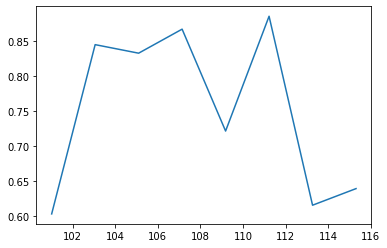

In [64]:
# note that if you want to set the parameters for the ROI extraction from the mzML, use the RioParams object
# e.g.
from vimms.Roi import RoiParams
roi_params = RoiParams(min_intensity=1000)
from vimms.ChemicalSamplers import MZMLChromatogramSampler
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

### MS2Sampler

This final class determines how chemicals will be assigned MS2 peaks. There are six options:

- `UniformMS2Sampler`: samples uniformly between a min mass and the mass of the formula
- `FixedMS2Sampler`: generates a fixed number of peaks, evenly spaced below the formula (mainly for testing)
- `CRPSMS2Sampler`: generates MS2 peaks using a Chinese Restaurant Process
- `MGFMS2Sampler`: generates MS2 spectra by sampling from those in an mgf file
- `ExactMatchMS2Sampler`: to be used in the case where objects in the MGF file share an ID with the database used for formula sampling
- `MZMLMS2Sampler`: samples MS2 spectra from an MS2 scan in an mzML file

In all cases, `sample` returns a list of masses, a list of intensties, and a *parent proportion* which is how much of the parents intensity gets transfered into the MS2 spectrum. The proportion is uniform between `min_proportion` and `max_proportion` which are passed to the constructors.

Examples:

In [74]:
def plot_spectrum(mz_list, intensity_list):
    plt.figure()
    for i,m in enumerate(mz_list):
        plt.plot([m,m],[0,intensity_list[i]])
class TempChemical:
    def __init__(self, mass):
        self.mass = mass

#### `UniformMS2Sampler`

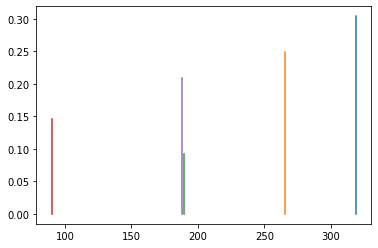

In [77]:
from vimms.ChemicalSamplers import UniformMS2Sampler
ms = UniformMS2Sampler(poiss_peak_mean=5) # number of fragments is decided by sample from poisson
tc = TempChemical(formula.mass)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `CRPMS2Sampler`

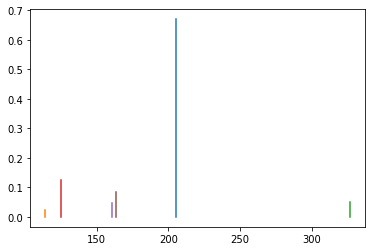

In [86]:
from vimms.ChemicalSamplers import CRPMS2Sampler
ms = CRPMS2Sampler(n_draws=500, alpha=1) # alpha and n_draws control the propery of the CRP
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `FixedMS2Sampler`

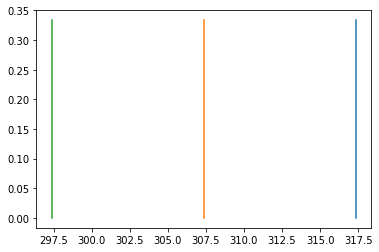

In [89]:
from vimms.ChemicalSamplers import FixedMS2Sampler
ms = FixedMS2Sampler(n_frags=3) # how many to make
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MGFMS2Sampler`

2020-09-11 08:15:02.571 | DEBUG    | vimms.ChemicalSamplers:__init__:476 - Loaded 411 spectra from /Users/simon/git/vimms/tests/fixtures/small_mgf.mgf


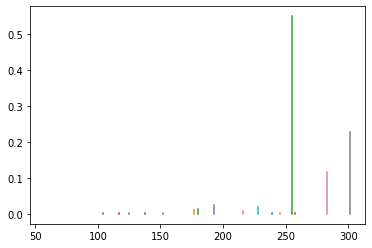

In [92]:
MGF = os.path.join(data_dir, 'small_mgf.mgf')
from vimms.ChemicalSamplers import MGFMS2Sampler
ms = MGFMS2Sampler(MGF)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MZMLMS2Sampler`

2020-09-11 08:15:38.552 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:534 - 331 MS2 scansn remaining


Loaded 364 scans


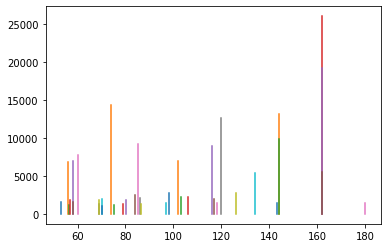

In [94]:
from vimms.ChemicalSamplers import MZMLMS2Sampler
ms = MZMLMS2Sampler(MZML)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `ExactMatchMS2Sampler`

2020-09-11 08:18:56.765 | DEBUG    | vimms.ChemicalSamplers:__init__:476 - Loaded 411 spectra from /Users/simon/git/vimms/tests/fixtures/small_mgf.mgf


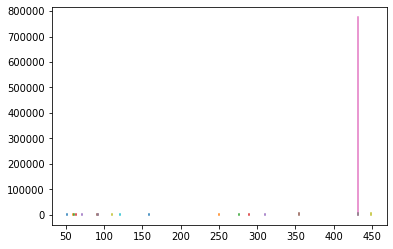

In [98]:
from vimms.ChemicalSamplers import ExactMatchMS2Sampler
# when formulas are sampled from a database, their accession is stored. We can cheat this as follows:
tc.database_accession = 'CCMSLIB00005435506'
# the MS2 sampler will then extract the spectrum that has the id_fiels set to this ID value
ms = ExactMatchMS2Sampler(MGF, id_field='SPECTRUMID')
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

## Everything together - `ChemicalMixtureCreator`

The simplest use is to just pass a formula sampler and let the rest go to defaults:

In [99]:
from vimms.Chemicals import ChemicalMixtureCreator
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
cm = ChemicalMixtureCreator(df)
chemicals = cm.sample(100,2) # sample 100 chemicals up to MS2

2020-09-11 08:20:28.058 | DEBUG    | vimms.ChemicalSamplers:sample:64 - 73822 unique formulas in filtered database
2020-09-11 08:20:28.060 | DEBUG    | vimms.ChemicalSamplers:sample:66 - Sampled formulas
2020-09-11 08:20:28.163 | DEBUG    | vimms.Chemicals:sample:693 - Sampled rt and intensity values and chromatograms


If more tailoring is required, pass the different samplers as arguments. E.g. if you wanted a CRPMS2Sampler and MZMLChromatograms:

In [103]:
cm = ChemicalMixtureCreator(df, ms2_sampler=CRPMS2Sampler(n_draws=100, alpha=2), chromatogram_sampler=MZMLChromatogramSampler(MZML))
chemicals = cm.sample(100,2)

2020-09-11 08:22:04.101 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:325 - Extracted 537 good ROIs from /Users/simon/git/vimms/tests/fixtures/small_mzml.mzML
2020-09-11 08:22:08.978 | DEBUG    | vimms.ChemicalSamplers:sample:64 - 73822 unique formulas in filtered database
2020-09-11 08:22:08.980 | DEBUG    | vimms.ChemicalSamplers:sample:66 - Sampled formulas
2020-09-11 08:22:09.004 | DEBUG    | vimms.Chemicals:sample:693 - Sampled rt and intensity values and chromatograms
